In [3]:
import numpy as np
import pandas as pd
import os
import matplotlib.cm as cm
from matplotlib import pyplot as plt
from scipy import stats as st
import seaborn as sns

from IPython.core.pylabtools import figsize

import numpy.random as r
from pylab import *
from matplotlib.gridspec import GridSpec

import sys
sys.path.insert(0, '../../utils')
import splicing_utils as spu
import single_cell_plots as scp
from single_cell_plots import *

plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 1
plt.rcParams["axes.facecolor"] = 'white'

import matplotlib as mpl
import numpy as np
from matplotlib import pyplot as plt

mpl.rcParams["mathtext.fontset"] = "stix"


In [4]:
%run -i 'load_data.py'

In [6]:
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from scipy.stats import zscore
from random import sample
from scipy.special import logit

from scipy.stats import pearsonr
from scipy.stats import spearmanr
def test_pearson(x, y):
    x_t = x.loc[x.dropna().index].index
    y_t = y.loc[y.dropna().index].index
    
    common = [z for z in x_t if z in y_t]
    
    return pearsonr(x.loc[common], y.loc[common])

In [7]:
kinetics_C57 = pd.read_csv('../../../data/kinetics/mES_kinetics_C57.csv', index_col=0)
kinetics_C57 = kinetics_C57.loc[~kinetics_C57.index.duplicated(keep='first')]
kinetics_CAST = pd.read_csv('../../../data/kinetics/mES_kinetics_CAST.csv', index_col=0)
kinetics_CAST = kinetics_CAST.loc[~kinetics_CAST.index.duplicated(keep='first')]

C57_mle_name = kinetics_C57.columns[0]
C57_freq_name = kinetics_C57.columns[1]
C57_size_name = kinetics_C57.columns[2]

CAST_mle_name = kinetics_CAST.columns[0]
CAST_freq_name = kinetics_CAST.columns[1]
CAST_size_name = kinetics_CAST.columns[2]


C57_freq = []
C57_size = []
for i in kinetics_C57.index:
    
    kon = kinetics_C57.loc[i, C57_mle_name][1:].split()[0]
    koff = kinetics_C57.loc[i, C57_mle_name][1:].split()[1]
    ksyn = kinetics_C57.loc[i, C57_mle_name][1:].split()[2][:-1]
    
    if kon[-1] == ',':
        print(kon)
        kon = kon[:-1]
    if koff[-1] == ',':
        print(koff)
        koff = koff[:-1]
    if ksyn[-1] == ',':
        print(ksyn)
        ksyn = ksyn[:-1]
    
    C57_freq.append(float(kon))
    C57_size.append(float(ksyn)/float(koff))
    
    
CAST_freq = []
CAST_size = []
    
for i in kinetics_CAST.index:
    
    CAST_freq.append(float(kinetics_CAST.loc[i, C57_mle_name][1:].split()[0]))
    
    koff = float(kinetics_CAST.loc[i, CAST_mle_name][1:].split()[1])
    ksyn = float(kinetics_CAST.loc[i, CAST_mle_name][1:].split()[2][:-1])
    
    CAST_size.append(ksyn/koff)
        

C57_kinetics = pd.DataFrame()
C57_kinetics['gene'] = kinetics_C57.index
C57_kinetics['C57_frequency'] = C57_freq
C57_kinetics['C57_size'] = C57_size
C57_kinetics = C57_kinetics.set_index('gene')

CAST_kinetics = pd.DataFrame()
CAST_kinetics['gene'] = kinetics_CAST.index
CAST_kinetics['CAST_frequency'] = CAST_freq
CAST_kinetics['CAST_size'] = CAST_size
CAST_kinetics = CAST_kinetics.set_index('gene')
kinetic_table = pd.concat([CAST_kinetics, C57_kinetics], axis=1)

chen_int_genes, chen_int_exons = spu.get_int_events(chen_PSI[chen_ES2i], chen_mrna_counts[chen_ES2i], min_unimodal = 0.2)

size_list = []
frequency_list = []
psi_binary = []
exon_lista = []
psi_std = []
psi_mean = []
for i in chen_int_exons:
    if i.split('_')[0] in kinetic_table.index:
        exon_lista.append(i)
        size_list.append(kinetic_table.loc[i.split('_')[0], ['C57_size', 'CAST_size']].mean())
        frequency_list.append(kinetic_table.loc[i.split('_')[0], ['C57_frequency', 'CAST_frequency']].mean())
        psi_binary.append((np.abs(0.5 - chen_PSI[chen_ES2i].loc[i]) >= 0.45).sum() / np.sum(~chen_PSI[chen_ES2i].loc[i].isna()))
        psi_std.append(chen_PSI[chen_ES2i].loc[i].std())
        psi_mean.append(chen_PSI[chen_ES2i].loc[i].mean())
        
        
burst_psi = pd.DataFrame()
burst_psi['exon'] = exon_lista
burst_psi['frequency'] = frequency_list
burst_psi['size'] = size_list
burst_psi['psi_std'] = psi_std
burst_psi['psi_mean'] = psi_mean
burst_psi['psi_binary'] = psi_binary
burst_psi = burst_psi.set_index('exon')

1.85595906,
47.25645625,


In [61]:
def test_burst(PSI_tab, mrna_counts, mrna_per_event, subpop, kinetic_table,  min_unimodal = 0.2):

    int_genes, int_exons = spu.get_int_events(PSI_tab[subpop], mrna_counts[subpop], min_unimodal = min_unimodal)

    size_list = []
    frequency_list = []
    psi_binary = []
    exon_lista = []
    psi_std = []
    psi_mean = []
    for i in int_exons:
        if i.split('_')[0] in kinetic_table.index:
            exon_lista.append(i)
            size_list.append(kinetic_table.loc[i.split('_')[0], ['C57_size', 'CAST_size']].mean())
            frequency_list.append(kinetic_table.loc[i.split('_')[0], ['C57_frequency', 'CAST_frequency']].mean())
            psi_binary.append((np.abs(0.5 - PSI_tab[subpop].loc[i]) >= 0.45).sum() / np.sum(~PSI_tab[subpop].loc[i].isna()))
            psi_std.append(PSI_tab[subpop].loc[i].std())
            psi_mean.append(PSI_tab[subpop].loc[i].mean())
        

    burst_psi = pd.DataFrame()
    burst_psi['exon'] = exon_lista
    burst_psi['frequency'] = np.log1p(frequency_list)
    burst_psi['size'] = np.log1p(size_list)
    burst_psi['psi_std'] = psi_std
    burst_psi['psi_mean'] = psi_mean
    burst_psi['psi_binary'] = psi_binary
    burst_psi = burst_psi.set_index('exon')

    burst_expression =  mrna_per_event.loc[burst_psi.index, subpop].mean(axis=1)
    
    burst_psi['mean_expression'] = np.log1p(burst_expression)
    
    low_exp = burst_expression.index[burst_expression <= burst_expression.quantile(0.25)]
    med_exp = burst_expression.index[(burst_expression > burst_expression.quantile(0.25)) & ((burst_expression <= burst_expression.quantile(0.5)))]
    med_high_exp = burst_expression.index[(burst_expression > burst_expression.quantile(0.5)) & ((burst_expression <= burst_expression.quantile(0.75)))]
    high_exp = burst_expression.index[burst_expression > burst_expression.quantile(0.75)]
    
    freq_cor_bin = []
    freq_cor_std = []
    
    size_cor_bin = []
    size_cor_std = []
    
    freq_cor_bin.append(test_pearson(np.log10(burst_psi.loc[low_exp, 'frequency']+1), burst_psi.loc[low_exp, 'psi_binary']))
    freq_cor_bin.append(test_pearson(np.log10(burst_psi.loc[med_exp, 'frequency']+1), burst_psi.loc[med_exp, 'psi_binary']))
    freq_cor_bin.append(test_pearson(np.log10(burst_psi.loc[med_high_exp, 'frequency']+1), burst_psi.loc[med_high_exp, 'psi_binary']))
    freq_cor_bin.append(test_pearson(np.log10(burst_psi.loc[high_exp, 'frequency']+1), burst_psi.loc[high_exp, 'psi_binary']))
    
    freq_cor_std.append(test_pearson(np.log10(burst_psi.loc[low_exp, 'frequency']+1), burst_psi.loc[low_exp, 'psi_std']))
    freq_cor_std.append(test_pearson(np.log10(burst_psi.loc[med_exp, 'frequency']+1), burst_psi.loc[med_exp, 'psi_std']))
    freq_cor_std.append(test_pearson(np.log10(burst_psi.loc[med_high_exp, 'frequency']+1), burst_psi.loc[med_high_exp, 'psi_std']))
    freq_cor_std.append(test_pearson(np.log10(burst_psi.loc[high_exp, 'frequency']+1), burst_psi.loc[high_exp, 'psi_std']))
    
    size_cor_bin.append(test_pearson(np.log10(burst_psi.loc[low_exp, 'size']+1), burst_psi.loc[low_exp, 'psi_binary']))
    size_cor_bin.append(test_pearson(np.log10(burst_psi.loc[med_exp, 'size']+1), burst_psi.loc[med_exp, 'psi_binary']))
    size_cor_bin.append(test_pearson(np.log10(burst_psi.loc[med_high_exp, 'size']+1), burst_psi.loc[med_high_exp, 'psi_binary']))
    size_cor_bin.append(test_pearson(np.log10(burst_psi.loc[high_exp, 'size']+1), burst_psi.loc[high_exp, 'psi_binary']))
    
    size_cor_std.append(test_pearson(np.log10(burst_psi.loc[low_exp, 'size']+1), burst_psi.loc[low_exp, 'psi_std']))
    size_cor_std.append(test_pearson(np.log10(burst_psi.loc[med_exp, 'size']+1), burst_psi.loc[med_exp, 'psi_std']))
    size_cor_std.append(test_pearson(np.log10(burst_psi.loc[med_high_exp, 'size']+1), burst_psi.loc[med_high_exp, 'psi_std']))
    size_cor_std.append(test_pearson(np.log10(burst_psi.loc[high_exp, 'size']+1), burst_psi.loc[high_exp, 'psi_std']))
    
    return freq_cor_bin, freq_cor_std, size_cor_bin, size_cor_std, burst_psi, low_exp, med_exp, med_high_exp, high_exp


In [97]:
ES2i_kinetics = test_burst(chen_PSI, chen_mrna_counts, mrna_per_event_chen, 
                           list(chen_ES2i), kinetic_table,  min_unimodal = 0.2)


load_data.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import single_cell_plots as scp


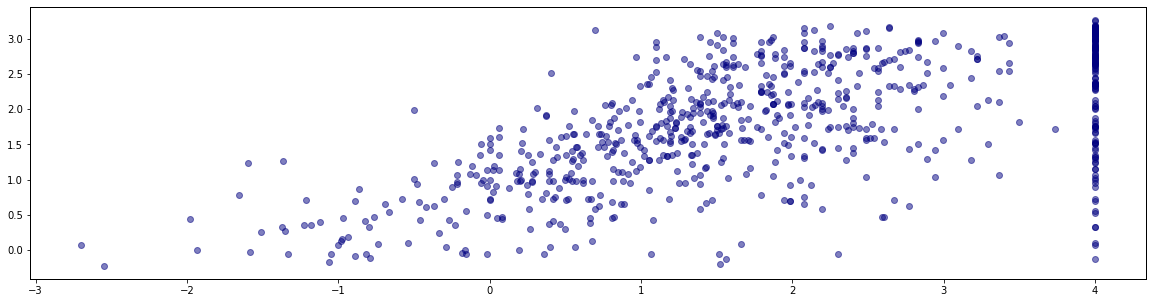

In [228]:
burst_psi_ES2i = ES2i_kinetics[4]
low_exp = ES2i_kinetics[5]
med_exp = ES2i_kinetics[6]
med_high_exp = ES2i_kinetics[7]
high_exp = ES2i_kinetics[8]

q75 = burst_psi_ES2i.mean_expression.quantile(0.05)
q95 = burst_psi_ES2i.mean_expression.quantile(0.95)
burst_psi_selected = burst_psi_ES2i.loc[(burst_psi_ES2i.mean_expression >= q75) & (burst_psi_ES2i.mean_expression <= q95)]
psi_corrected = []
for x in burst_psi_selected.psi_binary:
    if x <= 0.01:
        psi_corrected.append(0.01)
    elif x >= 0.99:
        psi_corrected.append(expit(4))
    else:
        psi_corrected.append(x)
        
burst_psi_selected['psi_corrected'] = list(logit(np.array(psi_corrected)))
# burst_psi_selected.loc[train, 'psi_corrected']

# train = sample(list(burst_psi_selected.index), int(burst_psi_selected.shape[0]*0.8))
# test = [x for x in burst_psi_selected.index if x not in train]

LR = LinearRegression()
LR.fit(burst_psi_selected[['frequency', 'size', 'mean_expression']], burst_psi_selected['psi_corrected'])

plt.scatter(burst_psi_selected['psi_corrected'], LR.predict(burst_psi_selected[['frequency', 'size', 'mean_expression']]), 
            alpha=0.5, c='navy')
plt.show()

In [223]:
LR = LinearRegression()
LR.fit(burst_psi_selected[['mean_expression']], burst_psi_selected['psi_binary'])

# plt.scatter(burst_psi_selected['psi_corrected'], LR.predict(burst_psi_selected[['frequency', 'size', 'mean_expression']]), 
#             alpha=0.5, c='navy')

print(LR.coef_)

[-0.15293296]


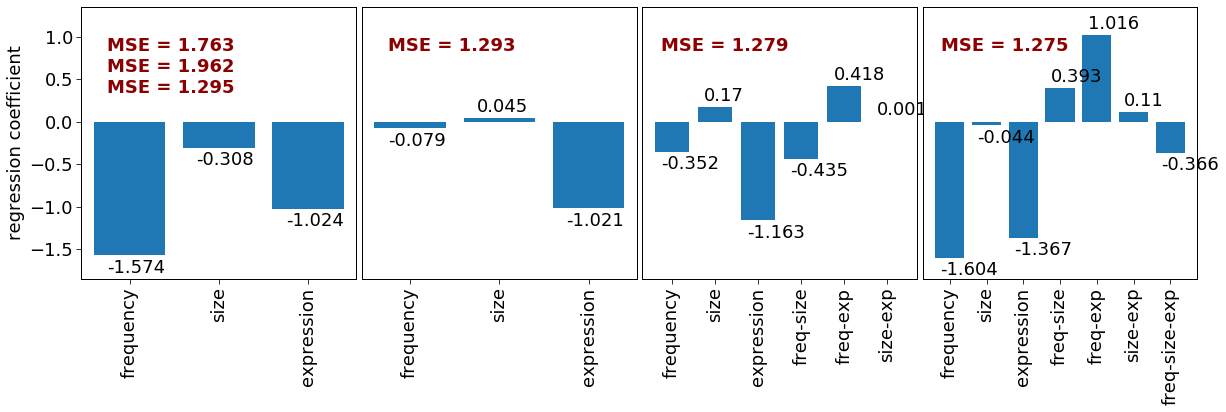

In [205]:
figsize(20, 5)
fig = plt.figure()

# fig.suptitle('p-values of anova test', fontsize=24)

gs = GridSpec(1,4)
gs.update(wspace=0.02, hspace=0.05)

ax_0 = fig.add_subplot(gs[0,0])
ax_1 = fig.add_subplot(gs[0,1])
ax_2 = fig.add_subplot(gs[0,2])
ax_3 = fig.add_subplot(gs[0,3])


mse_0 = []
lr_0 = []

LR = LinearRegression()
LR.fit(burst_psi_selected[['frequency']], burst_psi_selected['psi_corrected'])
lr_0.append(LR.coef_[0])
mse_0.append(str(round(mean_squared_error(burst_psi_selected['psi_corrected'], 
                   LR.predict(burst_psi_selected[['frequency']])), 3)))
LR = LinearRegression()
LR.fit(burst_psi_selected[['size']], burst_psi_selected['psi_corrected'])
lr_0.append(LR.coef_[0])
mse_0.append(str(round(mean_squared_error(burst_psi_selected['psi_corrected'], 
                   LR.predict(burst_psi_selected[['size']])), 3)))
LR = LinearRegression()
LR.fit(burst_psi_selected[['mean_expression']], burst_psi_selected['psi_corrected'])
lr_0.append(LR.coef_[0])
mse_0.append(str(round(mean_squared_error(burst_psi_selected['psi_corrected'], 
                   LR.predict(burst_psi_selected[['mean_expression']])), 3)))


ax_0.bar([0, 1, 2], lr_0)
ax_0.set_xticks([0, 1, 2])

ax_0.set_xticklabels(['frequency', 'size', 'expression'], rotation='vertical')    
# ax_1.ylabel('regression coefficient')
ax_0.set_ylabel('regression coefficient', fontsize = 18)
ax_0.tick_params(labelsize=18, length=5)


ax_0.text(-0.25, 1,'MSE = '+ mse_0[0], fontsize=18, verticalalignment='top', color='darkred', fontweight='bold')
ax_0.text(-0.25, 0.75,'MSE = '+ mse_0[1], fontsize=18, verticalalignment='top', color='darkred', fontweight='bold')
ax_0.text(-0.25, 0.5,'MSE = '+ mse_0[2], fontsize=18, verticalalignment='top', color='darkred', fontweight='bold')

for i, v in enumerate(lr_0):
    if v >= 0:
        ax_0.text(i + -.25, v + 0.075, str(round(v, 3)), fontsize=18)
    else:
        ax_0.text(i + -.25, v - 0.2, str(round(v, 3)), fontsize=18)



LR = LinearRegression()
LR.fit(burst_psi_selected[['frequency', 'size', 'mean_expression']], burst_psi_selected['psi_corrected'])

# plt.scatter(burst_psi_selected['psi_corrected'], LR.predict(burst_psi_selected[['frequency', 'size', 'mean_expression']]), 
#             alpha=0.5, c='navy')


ax_1.bar([0, 1, 2], LR.coef_)
ax_1.set_xticks([0, 1, 2])

ax_1.set_xticklabels(['frequency', 'size', 'expression'], rotation='vertical')    
# ax_1.ylabel('regression coefficient')
# ax_1.set_ylabel('regression coefficient', fontsize = 18)
ax_1.tick_params(labelsize=18, length=5)


mse_1 = str(round(mean_squared_error(burst_psi_selected['psi_corrected'], 
                   LR.predict(burst_psi_selected[['frequency', 'size', 'mean_expression']])), 3))

ax_1.text(-0.25, 1,'MSE = '+ mse_1, fontsize=18, verticalalignment='top', color='darkred', fontweight='bold')

for i, v in enumerate(LR.coef_):
    if v >= 0:
        ax_1.text(i + -.25, v + 0.075, str(round(v, 3)), fontsize=18)
    else:
        ax_1.text(i + -.25, v - 0.2, str(round(v, 3)), fontsize=18)


poly = PolynomialFeatures(2, interaction_only=True,include_bias = False)
X = poly.fit_transform(burst_psi_selected[['frequency', 'size', 'mean_expression']])

LR = LinearRegression()
LR.fit(X, burst_psi_selected['psi_corrected'])


ax_2.bar([0, 1, 2, 3, 4, 5], LR.coef_)

ax_2.set_xticks([0, 1, 2, 3, 4, 5])
ax_2.set_xticklabels(['frequency', 'size', 'expression', 'freq-size', 'freq-exp', 'size-exp'], 
                    rotation='vertical')    

ax_2.tick_params(labelsize=18, length=5)
plt.setp(ax_2.get_yticklabels(), visible=False)

mse_2 = str(round(mean_squared_error(burst_psi_selected['psi_corrected'], 
                   LR.predict(X)), 3))

ax_2.text(-0.25, 1,'MSE = '+ mse_2, fontsize=18, verticalalignment='top', color='darkred', fontweight='bold')
for i, v in enumerate(LR.coef_):
    if v >= 0:
        ax_2.text(i + -.25, v + 0.075, str(round(v, 3)), fontsize=18)
    else:
        ax_2.text(i + -.25, v - 0.2, str(round(v, 3)), fontsize=18)



poly = PolynomialFeatures(3, interaction_only=True,include_bias = False)
X = poly.fit_transform(burst_psi_selected[['frequency', 'size', 'mean_expression']])

LR = LinearRegression()
LR.fit(X, burst_psi_selected['psi_corrected'])
ax_3.bar([0, 1, 2, 3, 4, 5, 6], LR.coef_)



ax_3.set_xticks([0, 1, 2, 3, 4, 5, 6]) 
ax_3.set_xticklabels(['frequency', 'size', 'expression', 'freq-size', 'freq-exp', 'size-exp', 'freq-size-exp'], 
                    rotation='vertical')    


mse_3 = str(round(mean_squared_error(burst_psi_selected['psi_corrected'], 
                   LR.predict(X)), 3))

ax_3.text(-0.25, 1, 'MSE = '+ mse_3, fontsize=18, verticalalignment='top', color='darkred', fontweight='bold')

for i, v in enumerate(LR.coef_):
    if v >= 0:
        ax_3.text(i + -.25, v + 0.075, str(round(v, 3)), fontsize=18)
    else:
        ax_3.text(i + -.25, v - 0.2, str(round(v, 3)), fontsize=18)


ax_3.tick_params(labelsize=18, length=5)
plt.setp(ax_3.get_yticklabels(), visible=False)

ax_2.yaxis.set_ticks_position('none')
ax_3.yaxis.set_ticks_position('none')
ax_1.yaxis.set_ticks_position('none')
plt.setp(ax_1.get_yticklabels(), visible=False)


ax_1.set_ylim((-1.85, 1.35))
ax_2.set_ylim((-1.85, 1.35))
ax_3.set_ylim((-1.85, 1.35))
ax_0.set_ylim((-1.85, 1.35))
plt.show()

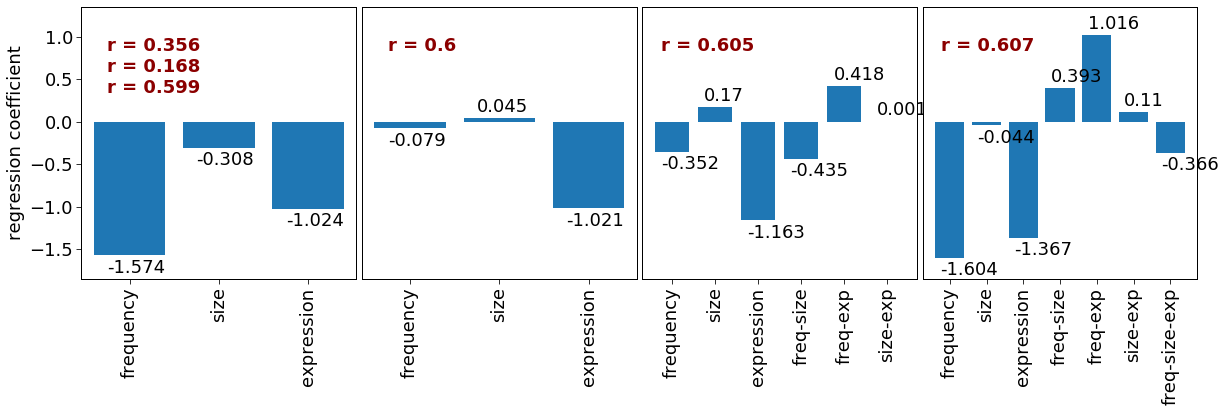

In [225]:
figsize(20, 5)
fig = plt.figure()

# fig.suptitle('p-values of anova test', fontsize=24)

gs = GridSpec(1,4)
gs.update(wspace=0.02, hspace=0.05)

ax_0 = fig.add_subplot(gs[0,0])
ax_1 = fig.add_subplot(gs[0,1])
ax_2 = fig.add_subplot(gs[0,2])
ax_3 = fig.add_subplot(gs[0,3])


r_0 = []
lr_0 = []

LR = LinearRegression()
LR.fit(burst_psi_selected[['frequency']], burst_psi_selected['psi_corrected'])
lr_0.append(LR.coef_[0])
r_0.append(str(round(pearsonr(burst_psi_selected['psi_corrected'], 
                   LR.predict(burst_psi_selected[['frequency']]))[0], 3)))
LR = LinearRegression()
LR.fit(burst_psi_selected[['size']], burst_psi_selected['psi_corrected'])
lr_0.append(LR.coef_[0])
r_0.append(str(round(pearsonr(burst_psi_selected['psi_corrected'], 
                   LR.predict(burst_psi_selected[['size']]))[0], 3)))
LR = LinearRegression()
LR.fit(burst_psi_selected[['mean_expression']], burst_psi_selected['psi_corrected'])
lr_0.append(LR.coef_[0])
r_0.append(str(round(pearsonr(burst_psi_selected['psi_corrected'], 
                   LR.predict(burst_psi_selected[['mean_expression']]))[0], 3)))


ax_0.bar([0, 1, 2], lr_0)
ax_0.set_xticks([0, 1, 2])

ax_0.set_xticklabels(['frequency', 'size', 'expression'], rotation='vertical')    
# ax_1.ylabel('regression coefficient')
ax_0.set_ylabel('regression coefficient', fontsize = 18)
ax_0.tick_params(labelsize=18, length=5)


ax_0.text(-0.25, 1,'r = '+ r_0[0], fontsize=18, verticalalignment='top', color='darkred', fontweight='bold')
ax_0.text(-0.25, 0.75,'r = '+ r_0[1], fontsize=18, verticalalignment='top', color='darkred', fontweight='bold')
ax_0.text(-0.25, 0.5,'r = '+ r_0[2], fontsize=18, verticalalignment='top', color='darkred', fontweight='bold')

for i, v in enumerate(lr_0):
    if v >= 0:
        ax_0.text(i + -.25, v + 0.075, str(round(v, 3)), fontsize=18)
    else:
        ax_0.text(i + -.25, v - 0.2, str(round(v, 3)), fontsize=18)



LR = LinearRegression()
LR.fit(burst_psi_selected[['frequency', 'size', 'mean_expression']], burst_psi_selected['psi_corrected'])

# plt.scatter(burst_psi_selected['psi_corrected'], LR.predict(burst_psi_selected[['frequency', 'size', 'mean_expression']]), 
#             alpha=0.5, c='navy')


ax_1.bar([0, 1, 2], LR.coef_)
ax_1.set_xticks([0, 1, 2])

ax_1.set_xticklabels(['frequency', 'size', 'expression'], rotation='vertical')    
# ax_1.ylabel('regression coefficient')
# ax_1.set_ylabel('regression coefficient', fontsize = 18)
ax_1.tick_params(labelsize=18, length=5)


r_1 = str(round(pearsonr(burst_psi_selected['psi_corrected'], 
                   LR.predict(burst_psi_selected[['frequency', 'size', 'mean_expression']]))[0], 3))

ax_1.text(-0.25, 1,'r = '+ r_1, fontsize=18, verticalalignment='top', color='darkred', fontweight='bold')

for i, v in enumerate(LR.coef_):
    if v >= 0:
        ax_1.text(i + -.25, v + 0.075, str(round(v, 3)), fontsize=18)
    else:
        ax_1.text(i + -.25, v - 0.2, str(round(v, 3)), fontsize=18)


poly = PolynomialFeatures(2, interaction_only=True,include_bias = False)
X = poly.fit_transform(burst_psi_selected[['frequency', 'size', 'mean_expression']])

LR = LinearRegression()
LR.fit(X, burst_psi_selected['psi_corrected'])


ax_2.bar([0, 1, 2, 3, 4, 5], LR.coef_)

ax_2.set_xticks([0, 1, 2, 3, 4, 5])
ax_2.set_xticklabels(['frequency', 'size', 'expression', 'freq-size', 'freq-exp', 'size-exp'], 
                    rotation='vertical')    

ax_2.tick_params(labelsize=18, length=5)
plt.setp(ax_2.get_yticklabels(), visible=False)

r_2 = str(round(pearsonr(burst_psi_selected['psi_corrected'], 
                   LR.predict(X))[0], 3))

ax_2.text(-0.25, 1,'r = '+ r_2, fontsize=18, verticalalignment='top', color='darkred', fontweight='bold')
for i, v in enumerate(LR.coef_):
    if v >= 0:
        ax_2.text(i + -.25, v + 0.075, str(round(v, 3)), fontsize=18)
    else:
        ax_2.text(i + -.25, v - 0.2, str(round(v, 3)), fontsize=18)



poly = PolynomialFeatures(3, interaction_only=True,include_bias = False)
X = poly.fit_transform(burst_psi_selected[['frequency', 'size', 'mean_expression']])

LR = LinearRegression()
LR.fit(X, burst_psi_selected['psi_corrected'])
ax_3.bar([0, 1, 2, 3, 4, 5, 6], LR.coef_)



ax_3.set_xticks([0, 1, 2, 3, 4, 5, 6]) 
ax_3.set_xticklabels(['frequency', 'size', 'expression', 'freq-size', 'freq-exp', 'size-exp', 'freq-size-exp'], 
                    rotation='vertical')    


r_3 = str(round(pearsonr(burst_psi_selected['psi_corrected'], 
                   LR.predict(X))[0], 3))

ax_3.text(-0.25, 1, 'r = '+ r_3, fontsize=18, verticalalignment='top', color='darkred', fontweight='bold')

for i, v in enumerate(LR.coef_):
    if v >= 0:
        ax_3.text(i + -.25, v + 0.075, str(round(v, 3)), fontsize=18)
    else:
        ax_3.text(i + -.25, v - 0.2, str(round(v, 3)), fontsize=18)


ax_3.tick_params(labelsize=18, length=5)
plt.setp(ax_3.get_yticklabels(), visible=False)

ax_2.yaxis.set_ticks_position('none')
ax_3.yaxis.set_ticks_position('none')
ax_1.yaxis.set_ticks_position('none')
plt.setp(ax_1.get_yticklabels(), visible=False)


ax_1.set_ylim((-1.85, 1.35))
ax_2.set_ylim((-1.85, 1.35))
ax_3.set_ylim((-1.85, 1.35))
ax_0.set_ylim((-1.85, 1.35))
plt.show()

In [212]:
.168**2

0.028224000000000003

In [207]:
from sklearn.metrics import r2_score

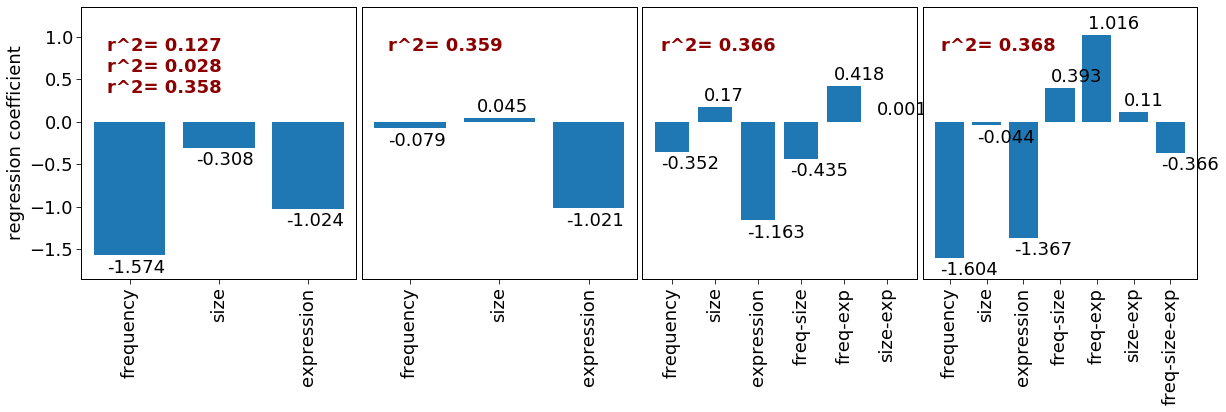

In [210]:
figsize(20, 5)
fig = plt.figure()

# fig.suptitle('p-values of anova test', fontsize=24)

gs = GridSpec(1,4)
gs.update(wspace=0.02, hspace=0.05)

ax_0 = fig.add_subplot(gs[0,0])
ax_1 = fig.add_subplot(gs[0,1])
ax_2 = fig.add_subplot(gs[0,2])
ax_3 = fig.add_subplot(gs[0,3])


r_0 = []
lr_0 = []

LR = LinearRegression()
LR.fit(burst_psi_selected[['frequency']], burst_psi_selected['psi_corrected'])
lr_0.append(LR.coef_[0])
r_0.append(str(round(r2_score(burst_psi_selected['psi_corrected'], 
                   LR.predict(burst_psi_selected[['frequency']])), 3)))
LR = LinearRegression()
LR.fit(burst_psi_selected[['size']], burst_psi_selected['psi_corrected'])
lr_0.append(LR.coef_[0])
r_0.append(str(round(r2_score(burst_psi_selected['psi_corrected'], 
                   LR.predict(burst_psi_selected[['size']])), 3)))
LR = LinearRegression()
LR.fit(burst_psi_selected[['mean_expression']], burst_psi_selected['psi_corrected'])
lr_0.append(LR.coef_[0])
r_0.append(str(round(r2_score(burst_psi_selected['psi_corrected'], 
                   LR.predict(burst_psi_selected[['mean_expression']])), 3)))


ax_0.bar([0, 1, 2], lr_0)
ax_0.set_xticks([0, 1, 2])

ax_0.set_xticklabels(['frequency', 'size', 'expression'], rotation='vertical')    
# ax_1.ylabel('regression coefficient')
ax_0.set_ylabel('regression coefficient', fontsize = 18)
ax_0.tick_params(labelsize=18, length=5)


ax_0.text(-0.25, 1,'r^2= '+ r_0[0], fontsize=18, verticalalignment='top', color='darkred', fontweight='bold')
ax_0.text(-0.25, 0.75,'r^2= '+ r_0[1], fontsize=18, verticalalignment='top', color='darkred', fontweight='bold')
ax_0.text(-0.25, 0.5,'r^2= '+ r_0[2], fontsize=18, verticalalignment='top', color='darkred', fontweight='bold')

for i, v in enumerate(lr_0):
    if v >= 0:
        ax_0.text(i + -.25, v + 0.075, str(round(v, 3)), fontsize=18)
    else:
        ax_0.text(i + -.25, v - 0.2, str(round(v, 3)), fontsize=18)



LR = LinearRegression()
LR.fit(burst_psi_selected[['frequency', 'size', 'mean_expression']], burst_psi_selected['psi_corrected'])

# plt.scatter(burst_psi_selected['psi_corrected'], LR.predict(burst_psi_selected[['frequency', 'size', 'mean_expression']]), 
#             alpha=0.5, c='navy')


ax_1.bar([0, 1, 2], LR.coef_)
ax_1.set_xticks([0, 1, 2])

ax_1.set_xticklabels(['frequency', 'size', 'expression'], rotation='vertical')    
# ax_1.ylabel('regression coefficient')
# ax_1.set_ylabel('regression coefficient', fontsize = 18)
ax_1.tick_params(labelsize=18, length=5)


r_1 = str(round(r2_score(burst_psi_selected['psi_corrected'], 
                   LR.predict(burst_psi_selected[['frequency', 'size', 'mean_expression']])), 3))

ax_1.text(-0.25, 1,'r^2= '+ r_1, fontsize=18, verticalalignment='top', color='darkred', fontweight='bold')

for i, v in enumerate(LR.coef_):
    if v >= 0:
        ax_1.text(i + -.25, v + 0.075, str(round(v, 3)), fontsize=18)
    else:
        ax_1.text(i + -.25, v - 0.2, str(round(v, 3)), fontsize=18)


poly = PolynomialFeatures(2, interaction_only=True,include_bias = False)
X = poly.fit_transform(burst_psi_selected[['frequency', 'size', 'mean_expression']])

LR = LinearRegression()
LR.fit(X, burst_psi_selected['psi_corrected'])


ax_2.bar([0, 1, 2, 3, 4, 5], LR.coef_)

ax_2.set_xticks([0, 1, 2, 3, 4, 5])
ax_2.set_xticklabels(['frequency', 'size', 'expression', 'freq-size', 'freq-exp', 'size-exp'], 
                    rotation='vertical')    

ax_2.tick_params(labelsize=18, length=5)
plt.setp(ax_2.get_yticklabels(), visible=False)

r_2 = str(round(r2_score(burst_psi_selected['psi_corrected'], 
                   LR.predict(X)), 3))

ax_2.text(-0.25, 1,'r^2= '+ r_2, fontsize=18, verticalalignment='top', color='darkred', fontweight='bold')
for i, v in enumerate(LR.coef_):
    if v >= 0:
        ax_2.text(i + -.25, v + 0.075, str(round(v, 3)), fontsize=18)
    else:
        ax_2.text(i + -.25, v - 0.2, str(round(v, 3)), fontsize=18)



poly = PolynomialFeatures(3, interaction_only=True,include_bias = False)
X = poly.fit_transform(burst_psi_selected[['frequency', 'size', 'mean_expression']])

LR = LinearRegression()
LR.fit(X, burst_psi_selected['psi_corrected'])
ax_3.bar([0, 1, 2, 3, 4, 5, 6], LR.coef_)



ax_3.set_xticks([0, 1, 2, 3, 4, 5, 6]) 
ax_3.set_xticklabels(['frequency', 'size', 'expression', 'freq-size', 'freq-exp', 'size-exp', 'freq-size-exp'], 
                    rotation='vertical')    


r_3 = str(round(r2_score(burst_psi_selected['psi_corrected'], 
                   LR.predict(X)), 3))

ax_3.text(-0.25, 1, 'r^2= '+ r_3, fontsize=18, verticalalignment='top', color='darkred', fontweight='bold')

for i, v in enumerate(LR.coef_):
    if v >= 0:
        ax_3.text(i + -.25, v + 0.075, str(round(v, 3)), fontsize=18)
    else:
        ax_3.text(i + -.25, v - 0.2, str(round(v, 3)), fontsize=18)


ax_3.tick_params(labelsize=18, length=5)
plt.setp(ax_3.get_yticklabels(), visible=False)

ax_2.yaxis.set_ticks_position('none')
ax_3.yaxis.set_ticks_position('none')
ax_1.yaxis.set_ticks_position('none')
plt.setp(ax_1.get_yticklabels(), visible=False)


ax_1.set_ylim((-1.85, 1.35))
ax_2.set_ylim((-1.85, 1.35))
ax_3.set_ylim((-1.85, 1.35))
ax_0.set_ylim((-1.85, 1.35))
plt.show()

In [221]:
pearsonr(burst_psi_selected['size'], burst_psi_selected['mean_expression'])

(0.3265498121183097, 3.815001551060417e-20)

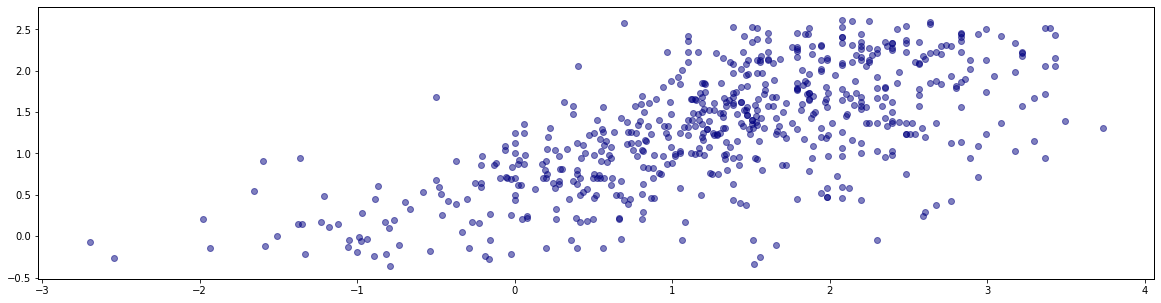

In [239]:
burst_psi_ES2i = ES2i_kinetics[4]
low_exp = ES2i_kinetics[5]
med_exp = ES2i_kinetics[6]
med_high_exp = ES2i_kinetics[7]
high_exp = ES2i_kinetics[8]

q75 = burst_psi_ES2i.mean_expression.quantile(0.05)
q95 = burst_psi_ES2i.mean_expression.quantile(0.95)
burst_psi_selected = burst_psi_ES2i.loc[(burst_psi_ES2i.mean_expression >= q75) & (burst_psi_ES2i.mean_expression <= q95)]


select = burst_psi_selected.index[(burst_psi_selected.psi_binary > 0.001) & ( burst_psi_selected.psi_binary < 0.999)]
burst_psi_selected = burst_psi_selected.loc[select]


burst_psi_selected['psi_corrected'] = list(logit(np.array(burst_psi_selected.psi_binary)))
# burst_psi_selected.loc[train, 'psi_corrected']

# train = sample(list(burst_psi_selected.index), int(burst_psi_selected.shape[0]*0.8))
# test = [x for x in burst_psi_selected.index if x not in train]

LR = LinearRegression()
LR.fit(burst_psi_selected[['frequency', 'size', 'mean_expression']], burst_psi_selected['psi_corrected'])

plt.scatter(burst_psi_selected['psi_corrected'], LR.predict(burst_psi_selected[['frequency', 'size', 'mean_expression']]), 
            alpha=0.5, c='navy')
plt.show()

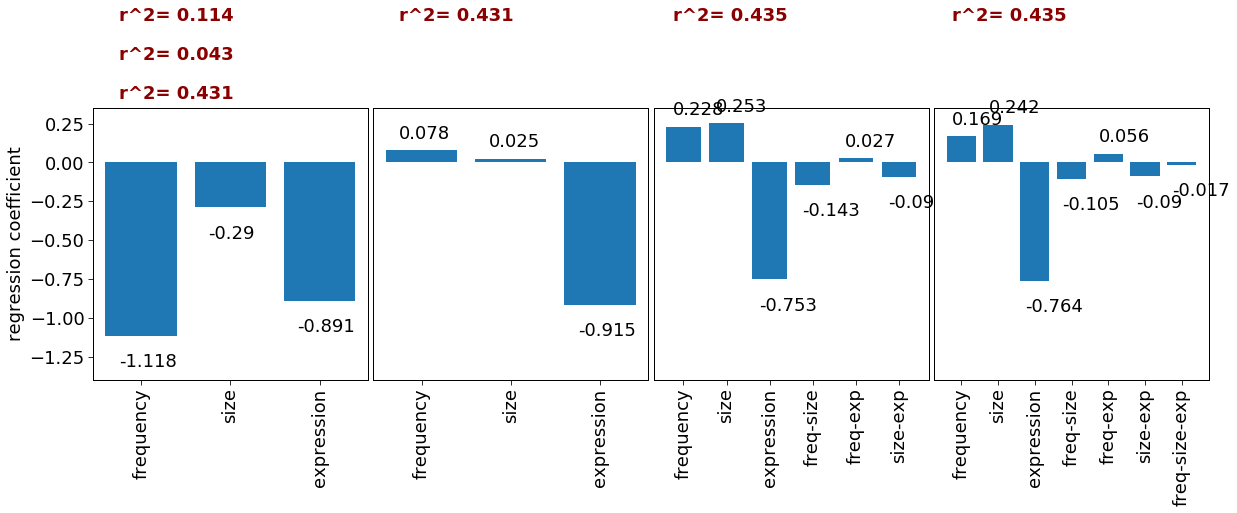

In [246]:
figsize(20, 5)
fig = plt.figure()

# fig.suptitle('p-values of anova test', fontsize=24)

gs = GridSpec(1,4)
gs.update(wspace=0.02, hspace=0.05)

ax_0 = fig.add_subplot(gs[0,0])
ax_1 = fig.add_subplot(gs[0,1])
ax_2 = fig.add_subplot(gs[0,2])
ax_3 = fig.add_subplot(gs[0,3])


r_0 = []
lr_0 = []

LR = LinearRegression()
LR.fit(burst_psi_selected[['frequency']], burst_psi_selected['psi_corrected'])
lr_0.append(LR.coef_[0])
r_0.append(str(round(r2_score(burst_psi_selected['psi_corrected'], 
                   LR.predict(burst_psi_selected[['frequency']])), 3)))
LR = LinearRegression()
LR.fit(burst_psi_selected[['size']], burst_psi_selected['psi_corrected'])
lr_0.append(LR.coef_[0])
r_0.append(str(round(r2_score(burst_psi_selected['psi_corrected'], 
                   LR.predict(burst_psi_selected[['size']])), 3)))
LR = LinearRegression()
LR.fit(burst_psi_selected[['mean_expression']], burst_psi_selected['psi_corrected'])
lr_0.append(LR.coef_[0])
r_0.append(str(round(r2_score(burst_psi_selected['psi_corrected'], 
                   LR.predict(burst_psi_selected[['mean_expression']])), 3)))


ax_0.bar([0, 1, 2], lr_0)
ax_0.set_xticks([0, 1, 2])

ax_0.set_xticklabels(['frequency', 'size', 'expression'], rotation='vertical')    
# ax_1.ylabel('regression coefficient')
ax_0.set_ylabel('regression coefficient', fontsize = 18)
ax_0.tick_params(labelsize=18, length=5)


ax_0.text(-0.25, 1,'r^2= '+ r_0[0], fontsize=18, verticalalignment='top', color='darkred', fontweight='bold')
ax_0.text(-0.25, 0.75,'r^2= '+ r_0[1], fontsize=18, verticalalignment='top', color='darkred', fontweight='bold')
ax_0.text(-0.25, 0.5,'r^2= '+ r_0[2], fontsize=18, verticalalignment='top', color='darkred', fontweight='bold')

for i, v in enumerate(lr_0):
    if v >= 0:
        ax_0.text(i + -.25, v + 0.075, str(round(v, 3)), fontsize=18)
    else:
        ax_0.text(i + -.25, v - 0.2, str(round(v, 3)), fontsize=18)



LR = LinearRegression()
LR.fit(burst_psi_selected[['frequency', 'size', 'mean_expression']], burst_psi_selected['psi_corrected'])

# plt.scatter(burst_psi_selected['psi_corrected'], LR.predict(burst_psi_selected[['frequency', 'size', 'mean_expression']]), 
#             alpha=0.5, c='navy')


ax_1.bar([0, 1, 2], LR.coef_)
ax_1.set_xticks([0, 1, 2])

ax_1.set_xticklabels(['frequency', 'size', 'expression'], rotation='vertical')    
# ax_1.ylabel('regression coefficient')
# ax_1.set_ylabel('regression coefficient', fontsize = 18)
ax_1.tick_params(labelsize=18, length=5)


r_1 = str(round(r2_score(burst_psi_selected['psi_corrected'], 
                   LR.predict(burst_psi_selected[['frequency', 'size', 'mean_expression']])), 3))

ax_1.text(-0.25, 1,'r^2= '+ r_1, fontsize=18, verticalalignment='top', color='darkred', fontweight='bold')

for i, v in enumerate(LR.coef_):
    if v >= 0:
        ax_1.text(i + -.25, v + 0.075, str(round(v, 3)), fontsize=18)
    else:
        ax_1.text(i + -.25, v - 0.2, str(round(v, 3)), fontsize=18)


poly = PolynomialFeatures(2, interaction_only=True,include_bias = False)
X = poly.fit_transform(burst_psi_selected[['frequency', 'size', 'mean_expression']])

LR = LinearRegression()
LR.fit(X, burst_psi_selected['psi_corrected'])


ax_2.bar([0, 1, 2, 3, 4, 5], LR.coef_)

ax_2.set_xticks([0, 1, 2, 3, 4, 5])
ax_2.set_xticklabels(['frequency', 'size', 'expression', 'freq-size', 'freq-exp', 'size-exp'], 
                    rotation='vertical')    

ax_2.tick_params(labelsize=18, length=5)
plt.setp(ax_2.get_yticklabels(), visible=False)

r_2 = str(round(r2_score(burst_psi_selected['psi_corrected'], 
                   LR.predict(X)), 3))

ax_2.text(-0.25, 1,'r^2= '+ r_2, fontsize=18, verticalalignment='top', color='darkred', fontweight='bold')
for i, v in enumerate(LR.coef_):
    if v >= 0:
        ax_2.text(i + -.25, v + 0.075, str(round(v, 3)), fontsize=18)
    else:
        ax_2.text(i + -.25, v - 0.2, str(round(v, 3)), fontsize=18)



poly = PolynomialFeatures(3, interaction_only=True,include_bias = False)
X = poly.fit_transform(burst_psi_selected[['frequency', 'size', 'mean_expression']])

LR = LinearRegression()
LR.fit(X, burst_psi_selected['psi_corrected'])
ax_3.bar([0, 1, 2, 3, 4, 5, 6], LR.coef_)



ax_3.set_xticks([0, 1, 2, 3, 4, 5, 6]) 
ax_3.set_xticklabels(['frequency', 'size', 'expression', 'freq-size', 'freq-exp', 'size-exp', 'freq-size-exp'], 
                    rotation='vertical')    


r_3 = str(round(r2_score(burst_psi_selected['psi_corrected'], 
                   LR.predict(X)), 3))

ax_3.text(-0.25, 1, 'r^2= '+ r_3, fontsize=18, verticalalignment='top', color='darkred', fontweight='bold')

for i, v in enumerate(LR.coef_):
    if v >= 0:
        ax_3.text(i + -.25, v + 0.075, str(round(v, 3)), fontsize=18)
    else:
        ax_3.text(i + -.25, v - 0.2, str(round(v, 3)), fontsize=18)


ax_3.tick_params(labelsize=18, length=5)
plt.setp(ax_3.get_yticklabels(), visible=False)

ax_2.yaxis.set_ticks_position('none')
ax_3.yaxis.set_ticks_position('none')
ax_1.yaxis.set_ticks_position('none')
plt.setp(ax_1.get_yticklabels(), visible=False)


ax_1.set_ylim((-1.40, .35))
ax_2.set_ylim((-1.40, .35))
ax_3.set_ylim((-1.40, .35))
ax_0.set_ylim((-1.40, .35))
plt.show()

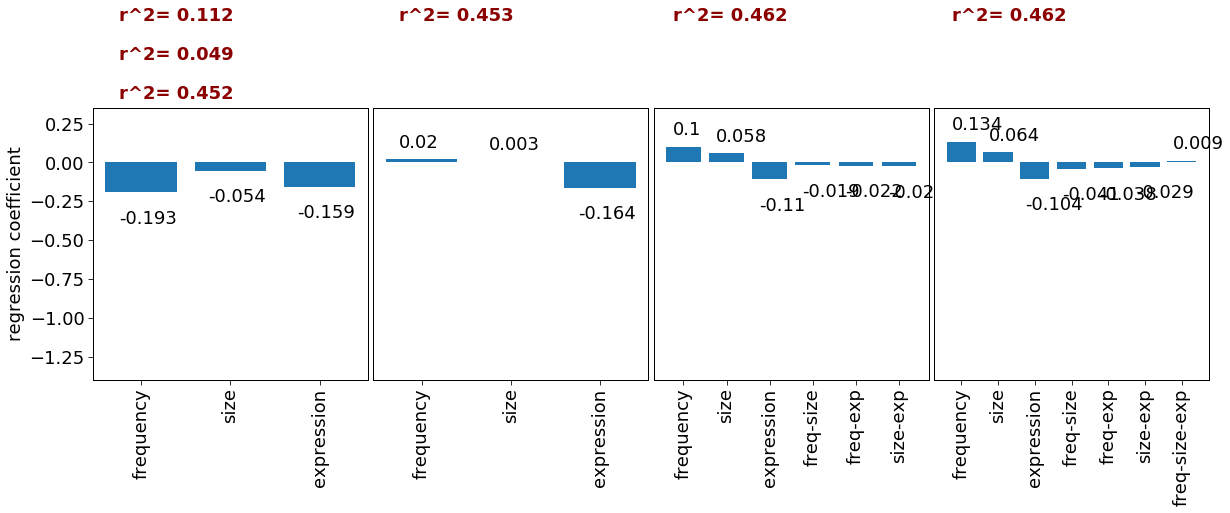

In [249]:
figsize(20, 5)
fig = plt.figure()

# fig.suptitle('p-values of anova test', fontsize=24)

gs = GridSpec(1,4)
gs.update(wspace=0.02, hspace=0.05)

ax_0 = fig.add_subplot(gs[0,0])
ax_1 = fig.add_subplot(gs[0,1])
ax_2 = fig.add_subplot(gs[0,2])
ax_3 = fig.add_subplot(gs[0,3])


r_0 = []
lr_0 = []

LR = LinearRegression()
LR.fit(burst_psi_selected[['frequency']], burst_psi_selected['psi_binary'])
lr_0.append(LR.coef_[0])
r_0.append(str(round(r2_score(burst_psi_selected['psi_binary'], 
                   LR.predict(burst_psi_selected[['frequency']])), 3)))
LR = LinearRegression()
LR.fit(burst_psi_selected[['size']], burst_psi_selected['psi_binary'])
lr_0.append(LR.coef_[0])
r_0.append(str(round(r2_score(burst_psi_selected['psi_binary'], 
                   LR.predict(burst_psi_selected[['size']])), 3)))
LR = LinearRegression()
LR.fit(burst_psi_selected[['mean_expression']], burst_psi_selected['psi_binary'])
lr_0.append(LR.coef_[0])
r_0.append(str(round(r2_score(burst_psi_selected['psi_binary'], 
                   LR.predict(burst_psi_selected[['mean_expression']])), 3)))


ax_0.bar([0, 1, 2], lr_0)
ax_0.set_xticks([0, 1, 2])

ax_0.set_xticklabels(['frequency', 'size', 'expression'], rotation='vertical')    
# ax_1.ylabel('regression coefficient')
ax_0.set_ylabel('regression coefficient', fontsize = 18)
ax_0.tick_params(labelsize=18, length=5)


ax_0.text(-0.25, 1,'r^2= '+ r_0[0], fontsize=18, verticalalignment='top', color='darkred', fontweight='bold')
ax_0.text(-0.25, 0.75,'r^2= '+ r_0[1], fontsize=18, verticalalignment='top', color='darkred', fontweight='bold')
ax_0.text(-0.25, 0.5,'r^2= '+ r_0[2], fontsize=18, verticalalignment='top', color='darkred', fontweight='bold')

for i, v in enumerate(lr_0):
    if v >= 0:
        ax_0.text(i + -.25, v + 0.075, str(round(v, 3)), fontsize=18)
    else:
        ax_0.text(i + -.25, v - 0.2, str(round(v, 3)), fontsize=18)



LR = LinearRegression()
LR.fit(burst_psi_selected[['frequency', 'size', 'mean_expression']], burst_psi_selected['psi_binary'])

# plt.scatter(burst_psi_selected['psi_binary'], LR.predict(burst_psi_selected[['frequency', 'size', 'mean_expression']]), 
#             alpha=0.5, c='navy')


ax_1.bar([0, 1, 2], LR.coef_)
ax_1.set_xticks([0, 1, 2])

ax_1.set_xticklabels(['frequency', 'size', 'expression'], rotation='vertical')    
# ax_1.ylabel('regression coefficient')
# ax_1.set_ylabel('regression coefficient', fontsize = 18)
ax_1.tick_params(labelsize=18, length=5)


r_1 = str(round(r2_score(burst_psi_selected['psi_binary'], 
                   LR.predict(burst_psi_selected[['frequency', 'size', 'mean_expression']])), 3))

ax_1.text(-0.25, 1,'r^2= '+ r_1, fontsize=18, verticalalignment='top', color='darkred', fontweight='bold')

for i, v in enumerate(LR.coef_):
    if v >= 0:
        ax_1.text(i + -.25, v + 0.075, str(round(v, 3)), fontsize=18)
    else:
        ax_1.text(i + -.25, v - 0.2, str(round(v, 3)), fontsize=18)


poly = PolynomialFeatures(2, interaction_only=True,include_bias = False)
X = poly.fit_transform(burst_psi_selected[['frequency', 'size', 'mean_expression']])

LR = LinearRegression()
LR.fit(X, burst_psi_selected['psi_binary'])


ax_2.bar([0, 1, 2, 3, 4, 5], LR.coef_)

ax_2.set_xticks([0, 1, 2, 3, 4, 5])
ax_2.set_xticklabels(['frequency', 'size', 'expression', 'freq-size', 'freq-exp', 'size-exp'], 
                    rotation='vertical')    

ax_2.tick_params(labelsize=18, length=5)
plt.setp(ax_2.get_yticklabels(), visible=False)

r_2 = str(round(r2_score(burst_psi_selected['psi_binary'], 
                   LR.predict(X)), 3))

ax_2.text(-0.25, 1,'r^2= '+ r_2, fontsize=18, verticalalignment='top', color='darkred', fontweight='bold')
for i, v in enumerate(LR.coef_):
    if v >= 0:
        ax_2.text(i + -.25, v + 0.075, str(round(v, 3)), fontsize=18)
    else:
        ax_2.text(i + -.25, v - 0.2, str(round(v, 3)), fontsize=18)



poly = PolynomialFeatures(3, interaction_only=True,include_bias = False)
X = poly.fit_transform(burst_psi_selected[['frequency', 'size', 'mean_expression']])

LR = LinearRegression()
LR.fit(X, burst_psi_selected['psi_binary'])
ax_3.bar([0, 1, 2, 3, 4, 5, 6], LR.coef_)



ax_3.set_xticks([0, 1, 2, 3, 4, 5, 6]) 
ax_3.set_xticklabels(['frequency', 'size', 'expression', 'freq-size', 'freq-exp', 'size-exp', 'freq-size-exp'], 
                    rotation='vertical')    


r_3 = str(round(r2_score(burst_psi_selected['psi_binary'], 
                   LR.predict(X)), 3))

ax_3.text(-0.25, 1, 'r^2= '+ r_3, fontsize=18, verticalalignment='top', color='darkred', fontweight='bold')

for i, v in enumerate(LR.coef_):
    if v >= 0:
        ax_3.text(i + -.25, v + 0.075, str(round(v, 3)), fontsize=18)
    else:
        ax_3.text(i + -.25, v - 0.2, str(round(v, 3)), fontsize=18)


ax_3.tick_params(labelsize=18, length=5)
plt.setp(ax_3.get_yticklabels(), visible=False)

ax_2.yaxis.set_ticks_position('none')
ax_3.yaxis.set_ticks_position('none')
ax_1.yaxis.set_ticks_position('none')
plt.setp(ax_1.get_yticklabels(), visible=False)


ax_1.set_ylim((-1.40, .35))
ax_2.set_ylim((-1.40, .35))
ax_3.set_ylim((-1.40, .35))
ax_0.set_ylim((-1.40, .35))
plt.show()

In [180]:


LR = LinearRegression()
LR.fit(burst_psi_selected[['frequency', 'size', 'mean_expression']], burst_psi_selected['psi_corrected'])

mean_squared_error(burst_psi_selected['psi_corrected'], 
                   LR.predict(burst_psi_selected[['frequency', 'size', 'mean_expression']]))

1.2932382572078653

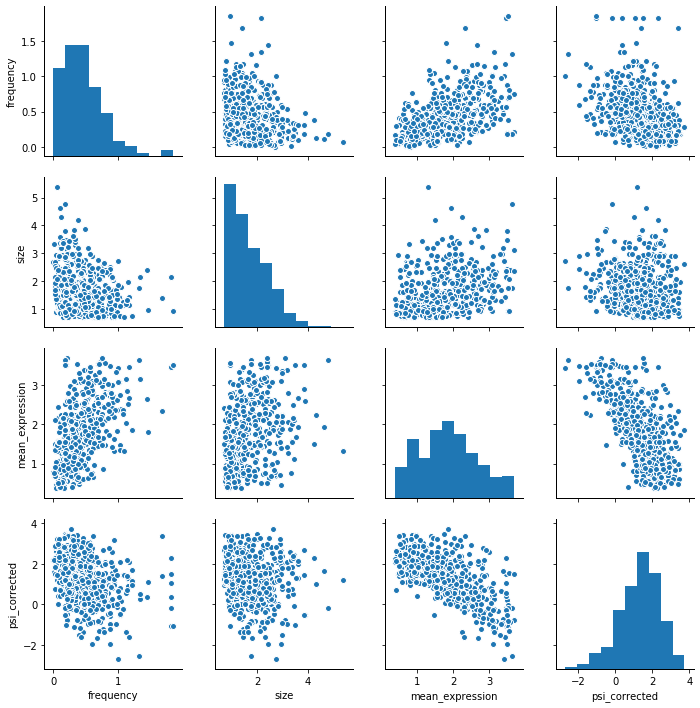

In [247]:
sns.pairplot(burst_psi_selected[['frequency', 'size', 'mean_expression', 'psi_corrected']])
plt.show()

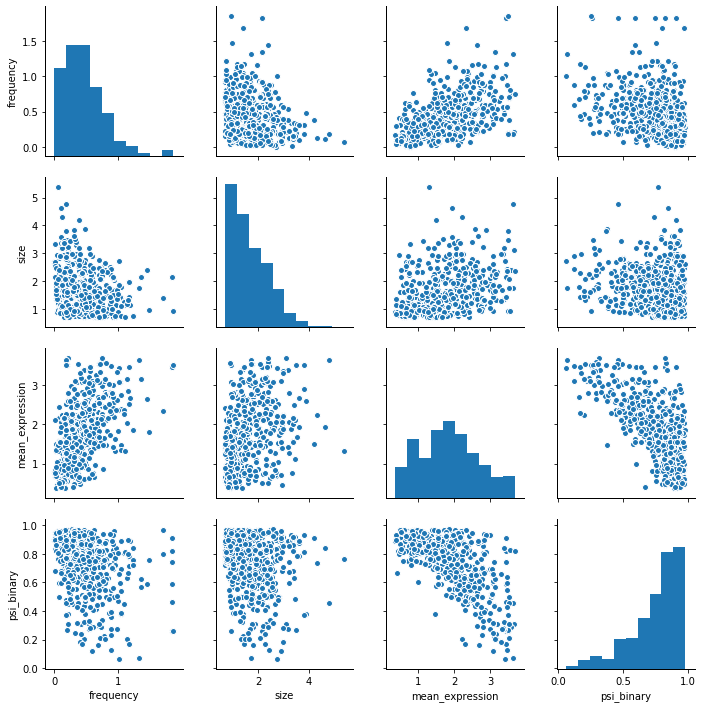

In [248]:
sns.pairplot(burst_psi_selected[['frequency', 'size', 'mean_expression', 'psi_binary']])
plt.show()

In [ ]:
figsize(20, 5)
fig = plt.figure()

# fig.suptitle('p-values of anova test', fontsize=24)

gs = GridSpec(1,4)
gs.update(wspace=0.02, hspace=0.05)

ax_0 = fig.add_subplot(gs[0,0])
ax_1 = fig.add_subplot(gs[0,1])
ax_2 = fig.add_subplot(gs[0,2])
ax_3 = fig.add_subplot(gs[0,3])


r_0 = []
lr_0 = []

LR = LinearRegression()
LR.fit(burst_psi_selected[['frequency']], burst_psi_selected['psi_binary'])
lr_0.append(LR.coef_[0])
r_0.append(str(round(r2_score(burst_psi_selected['psi_binary'], 
                   LR.predict(burst_psi_selected[['frequency']])), 3)))
LR = LinearRegression()
LR.fit(burst_psi_selected[['size']], burst_psi_selected['psi_binary'])
lr_0.append(LR.coef_[0])
r_0.append(str(round(r2_score(burst_psi_selected['psi_binary'], 
                   LR.predict(burst_psi_selected[['size']])), 3)))
LR = LinearRegression()
LR.fit(burst_psi_selected[['mean_expression']], burst_psi_selected['psi_binary'])
lr_0.append(LR.coef_[0])
r_0.append(str(round(r2_score(burst_psi_selected['psi_binary'], 
                   LR.predict(burst_psi_selected[['mean_expression']])), 3)))


ax_0.bar([0, 1, 2], lr_0)
ax_0.set_xticks([0, 1, 2])

ax_0.set_xticklabels(['frequency', 'size', 'expression'], rotation='vertical')    
# ax_1.ylabel('regression coefficient')
ax_0.set_ylabel('regression coefficient', fontsize = 18)
ax_0.tick_params(labelsize=18, length=5)


ax_0.text(-0.25, 1,'r^2= '+ r_0[0], fontsize=18, verticalalignment='top', color='darkred', fontweight='bold')
ax_0.text(-0.25, 0.75,'r^2= '+ r_0[1], fontsize=18, verticalalignment='top', color='darkred', fontweight='bold')
ax_0.text(-0.25, 0.5,'r^2= '+ r_0[2], fontsize=18, verticalalignment='top', color='darkred', fontweight='bold')

for i, v in enumerate(lr_0):
    if v >= 0:
        ax_0.text(i + -.25, v + 0.075, str(round(v, 3)), fontsize=18)
    else:
        ax_0.text(i + -.25, v - 0.2, str(round(v, 3)), fontsize=18)



LR = LinearRegression()
LR.fit(burst_psi_selected[['frequency', 'size', 'mean_expression']], burst_psi_selected['psi_binary'])

# plt.scatter(burst_psi_selected['psi_binary'], LR.predict(burst_psi_selected[['frequency', 'size', 'mean_expression']]), 
#             alpha=0.5, c='navy')


ax_1.bar([0, 1, 2], LR.coef_)
ax_1.set_xticks([0, 1, 2])

ax_1.set_xticklabels(['frequency', 'size', 'expression'], rotation='vertical')    
# ax_1.ylabel('regression coefficient')
# ax_1.set_ylabel('regression coefficient', fontsize = 18)
ax_1.tick_params(labelsize=18, length=5)


r_1 = str(round(r2_score(burst_psi_selected['psi_binary'], 
                   LR.predict(burst_psi_selected[['frequency', 'size', 'mean_expression']])), 3))

ax_1.text(-0.25, 1,'r^2= '+ r_1, fontsize=18, verticalalignment='top', color='darkred', fontweight='bold')

for i, v in enumerate(LR.coef_):
    if v >= 0:
        ax_1.text(i + -.25, v + 0.075, str(round(v, 3)), fontsize=18)
    else:
        ax_1.text(i + -.25, v - 0.2, str(round(v, 3)), fontsize=18)


poly = PolynomialFeatures(2, interaction_only=True,include_bias = False)
X = poly.fit_transform(burst_psi_selected[['frequency', 'size', 'mean_expression']])

LR = LinearRegression()
LR.fit(X, burst_psi_selected['psi_binary'])


ax_2.bar([0, 1, 2, 3, 4, 5], LR.coef_)

ax_2.set_xticks([0, 1, 2, 3, 4, 5])
ax_2.set_xticklabels(['frequency', 'size', 'expression', 'freq-size', 'freq-exp', 'size-exp'], 
                    rotation='vertical')    

ax_2.tick_params(labelsize=18, length=5)
plt.setp(ax_2.get_yticklabels(), visible=False)

r_2 = str(round(r2_score(burst_psi_selected['psi_binary'], 
                   LR.predict(X)), 3))

ax_2.text(-0.25, 1,'r^2= '+ r_2, fontsize=18, verticalalignment='top', color='darkred', fontweight='bold')
for i, v in enumerate(LR.coef_):
    if v >= 0:
        ax_2.text(i + -.25, v + 0.075, str(round(v, 3)), fontsize=18)
    else:
        ax_2.text(i + -.25, v - 0.2, str(round(v, 3)), fontsize=18)



poly = PolynomialFeatures(3, interaction_only=True,include_bias = False)
X = poly.fit_transform(burst_psi_selected[['frequency', 'size', 'mean_expression']])

LR = LinearRegression()
LR.fit(X, burst_psi_selected['psi_binary'])
ax_3.bar([0, 1, 2, 3, 4, 5, 6], LR.coef_)



ax_3.set_xticks([0, 1, 2, 3, 4, 5, 6]) 
ax_3.set_xticklabels(['frequency', 'size', 'expression', 'freq-size', 'freq-exp', 'size-exp', 'freq-size-exp'], 
                    rotation='vertical')    


r_3 = str(round(r2_score(burst_psi_selected['psi_binary'], 
                   LR.predict(X)), 3))

ax_3.text(-0.25, 1, 'r^2= '+ r_3, fontsize=18, verticalalignment='top', color='darkred', fontweight='bold')

for i, v in enumerate(LR.coef_):
    if v >= 0:
        ax_3.text(i + -.25, v + 0.075, str(round(v, 3)), fontsize=18)
    else:
        ax_3.text(i + -.25, v - 0.2, str(round(v, 3)), fontsize=18)


ax_3.tick_params(labelsize=18, length=5)
plt.setp(ax_3.get_yticklabels(), visible=False)

ax_2.yaxis.set_ticks_position('none')
ax_3.yaxis.set_ticks_position('none')
ax_1.yaxis.set_ticks_position('none')
plt.setp(ax_1.get_yticklabels(), visible=False)


ax_1.set_ylim((-1.40, .35))
ax_2.set_ylim((-1.40, .35))
ax_3.set_ylim((-1.40, .35))
ax_0.set_ylim((-1.40, .35))
plt.show()

In [340]:
poly = PolynomialFeatures(2, interaction_only=True,include_bias = False)
X = poly.fit_transform(burst_psi_selected[['frequency', 'size']])

In [341]:
X.shape

(619, 3)

In [330]:
def get_r2_score(X, target, metric='r2'):
    LR = LinearRegression()
    LR.fit(X, target)
    
    if metric == 'r2':
        r2 = r2_score(target, LR.predict(X))
        return r2
    
    elif metric == 'pearsonr':
        r = pearsonr(target, LR.predict(X))[0]
        return r
    
    else:
        mse = mean_squared_error(target, LR.predict(X))
        return mse



In [342]:
r2 = []
r2.append(get_r2_score(burst_psi_selected[['frequency']], burst_psi_selected['psi_corrected'], metric='pearsonr'))
r2.append(get_r2_score(burst_psi_selected[['size']], burst_psi_selected['psi_corrected'], metric='pearsonr'))
r2.append(get_r2_score(burst_psi_selected[['frequency', 'size']], burst_psi_selected['psi_corrected'], metric='pearsonr'))






r2.append(get_r2_score(burst_psi_selected[['mean_expression']], burst_psi_selected['psi_corrected'], metric='pearsonr'))
r2.append(get_r2_score(burst_psi_selected[['mean_expression', 'frequency']], burst_psi_selected['psi_corrected'], metric='pearsonr'))
r2.append(get_r2_score(burst_psi_selected[['mean_expression', 'size']], burst_psi_selected['psi_corrected'], metric='pearsonr'))
r2.append(get_r2_score(burst_psi_selected[['mean_expression', 'frequency', 'size']], burst_psi_selected['psi_corrected'], metric='pearsonr'))


poly = PolynomialFeatures(2, interaction_only=True,include_bias = False)
X = poly.fit_transform(burst_psi_selected[['frequency', 'size', 'mean_expression']])
r2.append(get_r2_score(X, burst_psi_selected['psi_corrected'], metric='pearsonr'))

# poly = PolynomialFeatures(2, interaction_only=False,include_bias = False)
# X = poly.fit_transform(burst_psi_selected[['frequency', 'size', 'mean_expression']])
# r2.append(get_r2_score(X, burst_psi_selected['psi_corrected']))

poly = PolynomialFeatures(3, interaction_only=True,include_bias = False)
X = poly.fit_transform(burst_psi_selected[['frequency', 'size', 'mean_expression']])
r2.append(get_r2_score(X, burst_psi_selected['psi_corrected'], metric='pearsonr'))

# poly = PolynomialFeatures(3, interaction_only=False,include_bias = False)
# X = poly.fit_transform(burst_psi_selected[['frequency', 'size', 'mean_expression']])
# r2.append(get_r2_score(X, burst_psi_selected['psi_corrected']))

Text(0, 0.5, 'Pearson $r$')

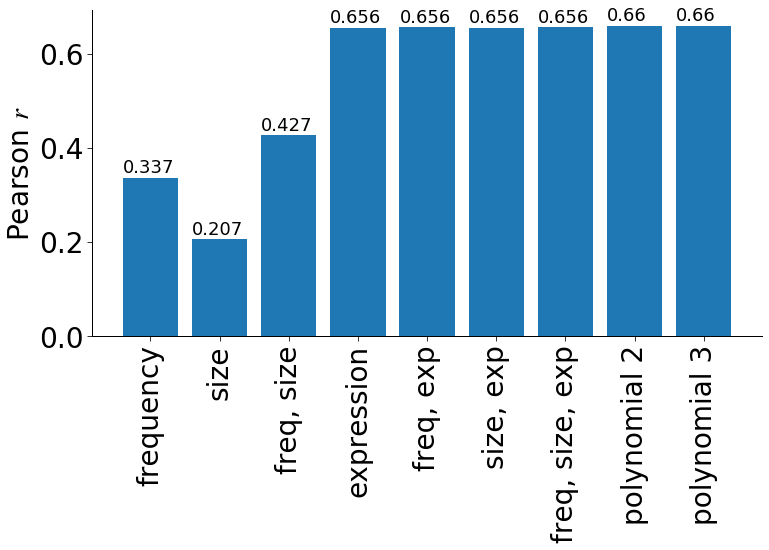

In [343]:
figsize(12, 6)

fig = plt.figure()
ax  = plt.subplot(1,1,1)


ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.tick_params(labelsize=28, length=5)
# plt.title('Recall curves, ' + dset_name, fontsize=28)
# plt.xlabel('-log10 p-value', fontsize=28)
# plt.ylabel('Recall', fontsize=28)
#     #plt.legend(frameon=False, fontsize=28)
plt.xticks([1, 2, 3, 4, 5], ['1', '2', '3', '4', '5'])

ax.bar(range(len(r2)), r2)

for i, v in enumerate(r2):
    ax.text(i + -.4, v + 0.01, str(round(v, 3)), fontsize=18)


# plt.xticks([0, 1, 2], ['frequency', 'size', 'expression'], fontsize=20, rotation='vertical')    
# plt.ylabel('regression coefficient')
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8], 
           ['frequency', 'size', 'freq, size', 'expression', 'freq, exp', 'size, exp', 'freq, size, exp',
           'polynomial 2', 'polynomial 3'], 
           fontsize=28, rotation='vertical')    
plt.ylabel('Pearson $r$', fontsize=28)

In [384]:
r2 = []
names = []
r2.append(get_r2_score(burst_psi_selected[['frequency']], burst_psi_selected['psi_corrected']))
names.append('freq')
r2.append(get_r2_score(burst_psi_selected[['size']], burst_psi_selected['psi_corrected']))
names.append('size')
r2.append(get_r2_score(burst_psi_selected[['frequency', 'size']], burst_psi_selected['psi_corrected']))
names.append('freq + size')

poly = PolynomialFeatures(2, interaction_only=True,include_bias = False)
X = poly.fit_transform(burst_psi_selected[['frequency', 'size']])
r2.append(get_r2_score(np.array([y[2] for y in X]).reshape(-1, 1) , burst_psi_selected['psi_corrected']))
names.append('freq*size')

# poly = PolynomialFeatures(2, interaction_only=True,include_bias = False)
# X = poly.fit_transform(burst_psi_selected[['frequency', 'size']])
# r2.append(get_r2_score(X , burst_psi_selected['psi_corrected']))
# names.append('freq+size+freq*size')

poly = PolynomialFeatures(2, interaction_only=True,include_bias = False)
X = poly.fit_transform(burst_psi_selected[['frequency', 'mean_expression']])
r2.append(get_r2_score(np.array([y[2] for y in X]).reshape(-1, 1) , burst_psi_selected['psi_corrected']))
names.append('freq*exp')


poly = PolynomialFeatures(2, interaction_only=True,include_bias = False)
X = poly.fit_transform(burst_psi_selected[['size', 'mean_expression']])
r2.append(get_r2_score(np.array([y[2] for y in X]).reshape(-1, 1) , burst_psi_selected['psi_corrected']))
names.append('size*exp')

poly = PolynomialFeatures(3, interaction_only=True,include_bias = False)
X = poly.fit_transform(burst_psi_selected[['frequency', 'size', 'mean_expression']])
r2.append(get_r2_score(np.array([y[-1] for y in X]).reshape(-1, 1), burst_psi_selected['psi_corrected']))
names.append('size*freq*exp')


r2.append(get_r2_score(burst_psi_selected[['mean_expression']], burst_psi_selected['psi_corrected']))
names.append('exp')

r2.append(get_r2_score(burst_psi_selected[['mean_expression', 'frequency']], burst_psi_selected['psi_corrected']))
names.append('exp + freq')



r2.append(get_r2_score(burst_psi_selected[['mean_expression', 'size']], burst_psi_selected['psi_corrected']))
names.append('exp + size')

r2.append(get_r2_score(burst_psi_selected[['mean_expression', 'frequency', 'size']], burst_psi_selected['psi_corrected']))
names.append('exp + freq + size')


poly = PolynomialFeatures(3, interaction_only=True,include_bias = False)
X = poly.fit_transform(burst_psi_selected[['frequency', 'size', 'mean_expression']])
r2.append(get_r2_score(X, burst_psi_selected['psi_corrected']))
names.append('all interactions')


# poly = PolynomialFeatures(3, interaction_only=True,include_bias = False)
# X = poly.fit_transform(burst_psi_selected[['frequency', 'size', 'mean_expression']])
# r2.append(get_r2_score(X, burst_psi_selected['psi_corrected']))


# poly = PolynomialFeatures(3, interaction_only=True,include_bias = False)
# X = poly.fit_transform(burst_psi_selected[['frequency', 'size', 'mean_expression']])
# r2.append(get_r2_score(np.array([y[-1] for y in X]).reshape(-1, 1), burst_psi_selected['psi_corrected']))


Text(0, 0.5, 'Regression $R^2$')

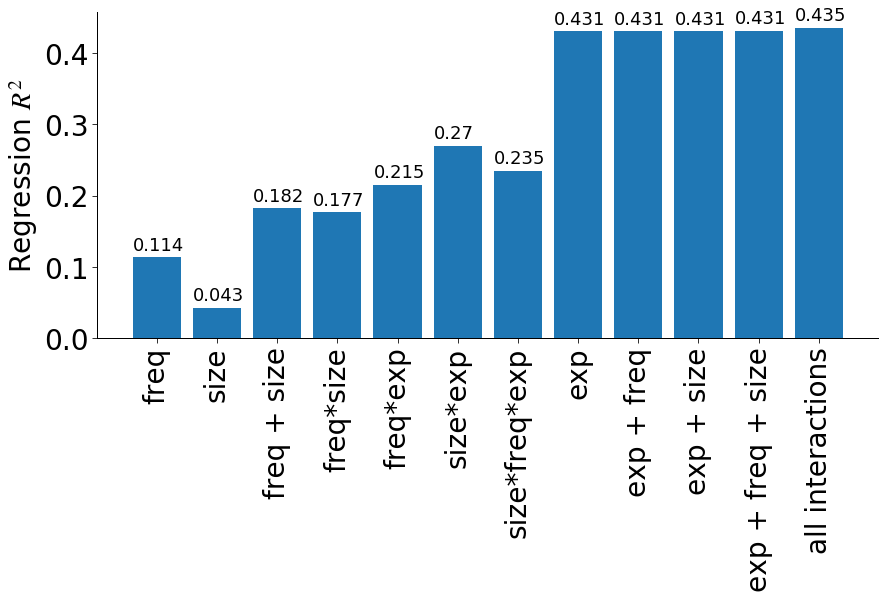

In [385]:
figsize(14, 6)

fig = plt.figure()
ax  = plt.subplot(1,1,1)


ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.tick_params(labelsize=28, length=5)
# plt.title('Recall curves, ' + dset_name, fontsize=28)
# plt.xlabel('-log10 p-value', fontsize=28)
# plt.ylabel('Recall', fontsize=28)
#     #plt.legend(frameon=False, fontsize=28)
# plt.xticks([1, 2, 3, 4, 5], ['1', '2', '3', '4', '5'])

ax.bar(range(len(r2)), r2)

for i, v in enumerate(r2):
    ax.text(i + -.4, v + 0.01, str(round(v, 3)), fontsize=18)


# plt.xticks([0, 1, 2], ['frequency', 'size', 'expression'], fontsize=20, rotation='vertical')    
# plt.ylabel('regression coefficient')
plt.xticks(range(len(names)), names, 
           fontsize=28, rotation='vertical')    
plt.ylabel('Regression $R^2$', fontsize=28)

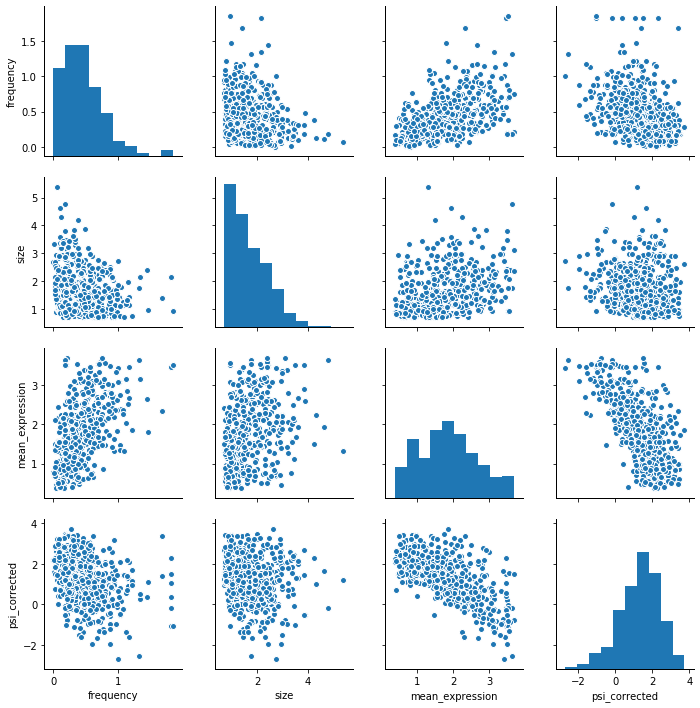

In [373]:
sns.pairplot(burst_psi_selected[['frequency', 'size', 'mean_expression', 'psi_corrected']])
plt.show()

In [149]:
from sklearn.preprocessing import PolynomialFeatures


In [150]:
# poly.get_feature_names()

['x0', 'x1', 'x2', 'x0 x1', 'x0 x2', 'x1 x2', 'x0 x1 x2']

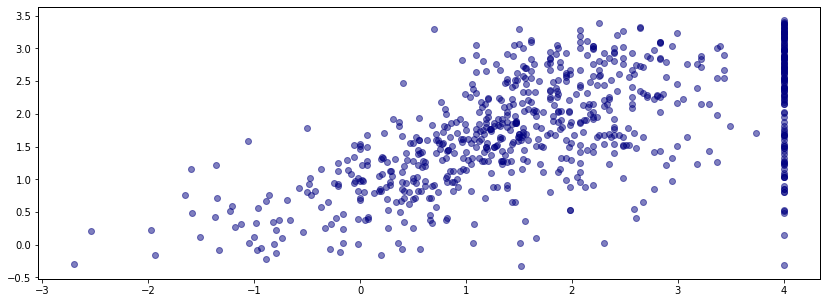

In [151]:
poly = PolynomialFeatures(3, interaction_only=True,include_bias = False)
X = poly.fit_transform(burst_psi_selected[['frequency', 'size', 'mean_expression']])

LR = LinearRegression()
LR.fit(X, burst_psi_selected['psi_corrected'])

plt.scatter(burst_psi_selected['psi_corrected'], LR.predict(X), 
            alpha=0.5, c='navy')
plt.show()

In [152]:
ax_3.bar([0, 1, 2, 3, 4, 5, 6], LR.coef_)



ax_3.set_xticks([0, 1, 2, 3, 4, 5, 6], 
           ['frequency', 'size', 'expression', 'freq-size', 'freq-exp', 'size-exp', 'freq-size-exp'])    


NameError: name 'ax_3' is not defined

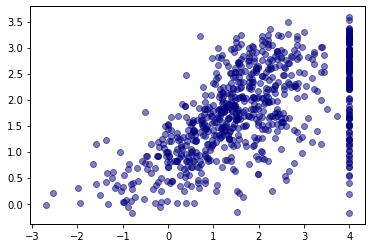

Text(0, 0.5, 'regression coefficient')

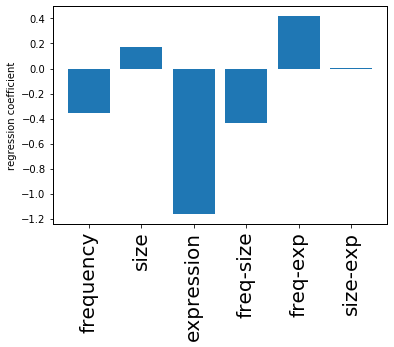

In [137]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(2, interaction_only=True,include_bias = False)
X = poly.fit_transform(burst_psi_selected[['frequency', 'size', 'mean_expression']])

LR = LinearRegression()
LR.fit(X, burst_psi_selected['psi_corrected'])

plt.scatter(burst_psi_selected['psi_corrected'], LR.predict(X), 
            alpha=0.5, c='navy')
plt.show()

plt.bar([0, 1, 2, 3, 4, 5], LR.coef_)
plt.xticks([0, 1, 2, 3, 4, 5], 
           ['frequency', 'size', 'expression', 'freq-size', 'freq-exp', 'size-exp'], 
           fontsize=20, rotation='vertical')    
plt.ylabel('regression coefficient')


In [139]:
poly.get_feature_names()

['x0', 'x1', 'x2', 'x0 x1', 'x0 x2', 'x1 x2']

load_data.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import single_cell_plots as scp


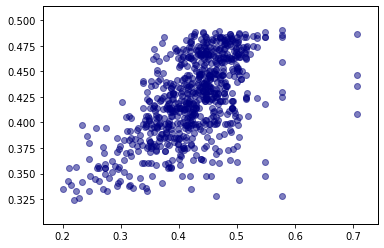

In [101]:
burst_psi_ES2i = ES2i_kinetics[4]
low_exp = ES2i_kinetics[5]
med_exp = ES2i_kinetics[6]
med_high_exp = ES2i_kinetics[7]
high_exp = ES2i_kinetics[8]

q75 = burst_psi_ES2i.mean_expression.quantile(0.05)
q95 = burst_psi_ES2i.mean_expression.quantile(0.95)
burst_psi_selected = burst_psi_ES2i.loc[(burst_psi_ES2i.mean_expression >= q75) & (burst_psi_ES2i.mean_expression <= q95)]
psi_corrected = []
for x in burst_psi_selected.psi_binary:
    if x <= 0.01:
        psi_corrected.append(0.01)
    elif x >= 0.99:
        psi_corrected.append(expit(4))
    else:
        psi_corrected.append(x)
        
burst_psi_selected['psi_corrected'] = list(logit(np.array(psi_corrected)))
# burst_psi_selected.loc[train, 'psi_corrected']

# train = sample(list(burst_psi_selected.index), int(burst_psi_selected.shape[0]*0.8))
# test = [x for x in burst_psi_selected.index if x not in train]

LR = LinearRegression()
LR.fit(burst_psi_selected[['frequency', 'size', 'mean_expression']], burst_psi_selected['psi_std'])

plt.scatter(burst_psi_selected['psi_std'], LR.predict(burst_psi_selected[['frequency', 'size', 'mean_expression']]), 
            alpha=0.5, c='navy')
plt.show()

Text(0, 0.5, 'regression coefficient')

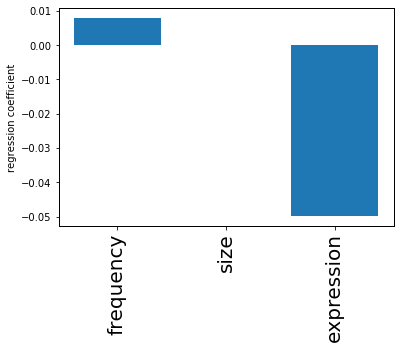

In [102]:
plt.bar([0, 1, 2], LR.coef_)
plt.xticks([0, 1, 2], ['frequency', 'size', 'expression'], fontsize=20, rotation='vertical')    
plt.ylabel('regression coefficient')


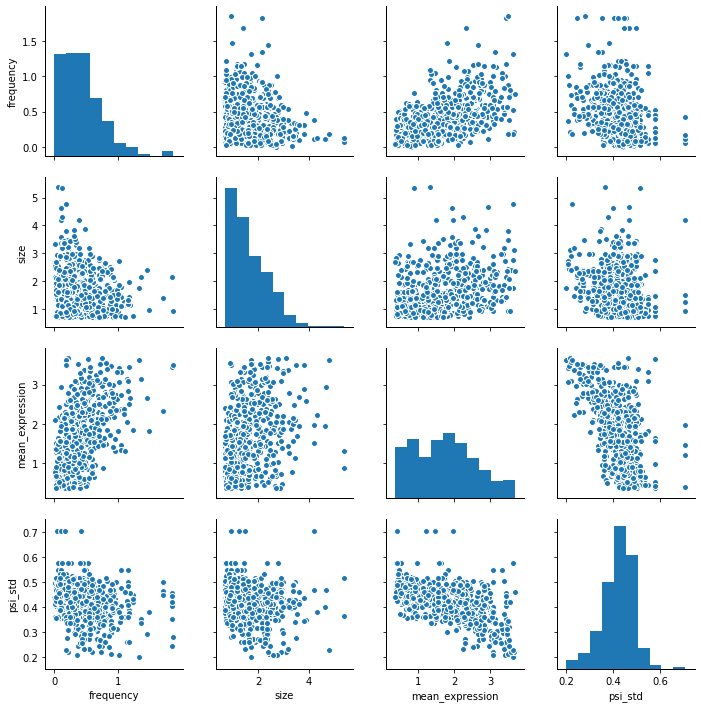

In [103]:
sns.pairplot(burst_psi_selected[['frequency', 'size', 'mean_expression', 'psi_std']])
plt.show()

In [ ]:
train = sample(list(burst_psi_selected.index), int(burst_psi_selected.shape[0]*0.8))
test = [x for x in burst_psi_selected.index if x not in train]

LR = LinearRegression()
LR.fit(burst_psi_selected.loc[train, ['frequency', 'size', 'mean_expression']], burst_psi_selected.loc[train, 'psi_corrected'])

plt.scatter(burst_psi_selected.loc[train, 'psi_corrected'], LR.predict(burst_psi_selected.loc[train, 
                                            ['frequency', 'size', 'mean_expression']]), alpha=0.5, c='navy')
plt.show()

load_data.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from matplotlib.gridspec import GridSpec


Text(0, 0.5, 'regression coefficient')

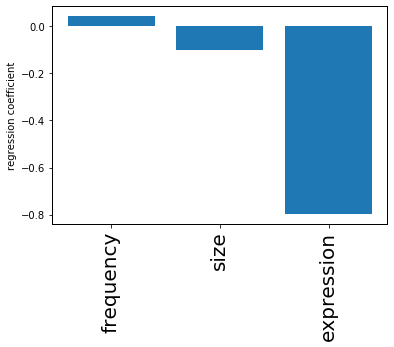

In [66]:
q75 = burst_psi_ES2i.mean_expression.quantile(0.75)
q95 = burst_psi_ES2i.mean_expression.quantile(0.95)
burst_psi_selected = burst_psi_ES2i.loc[(burst_psi_ES2i.mean_expression >= q75) & (burst_psi_ES2i.mean_expression <= q95)]
psi_corrected = []
for x in burst_psi_selected.psi_binary:
    if x <= 0.01:
        psi_corrected.append(0.01)
    elif x >= 0.99:
        psi_corrected.append(0.99)
    else:
        psi_corrected.append(x)
        
burst_psi_selected['psi_corrected'] = list(logit(np.array(psi_corrected)))
# burst_psi_selected.loc[train, 'psi_corrected']
train = sample(list(burst_psi_selected.index), int(burst_psi_selected.shape[0]*0.8))
test = [x for x in burst_psi_selected.index if x not in train]
LR = LinearRegression()
LR.fit(burst_psi_selected.loc[train, ['frequency', 'size', 'mean_expression']], burst_psi_selected.loc[train, 'psi_corrected'])

mean_squared_error(burst_psi_selected.loc[train, 'psi_corrected'], 
            LR.predict(burst_psi_selected.loc[train, ['frequency', 'size', 'mean_expression']]))

plt.bar([0, 1, 2], LR.coef_)
plt.xticks([0, 1, 2], ['frequency', 'size', 'expression'], fontsize=20, rotation='vertical')    
plt.ylabel('regression coefficient')


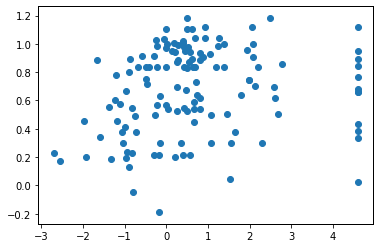

In [67]:
plt.scatter(burst_psi_selected.loc[train, 'psi_corrected'], LR.predict(burst_psi_selected.loc[train, 
                                            ['frequency', 'size', 'mean_expression']]))
plt.show()

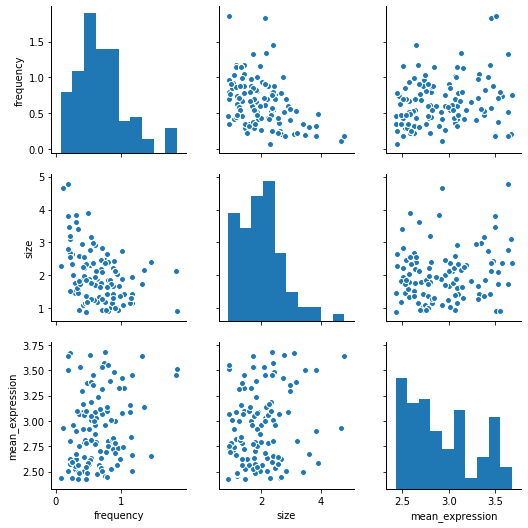

In [68]:
sns.pairplot(burst_psi_selected[['frequency', 'size', 'mean_expression']])
plt.show()